In [1]:
# Model structure
# input layer >> 2D CNN >> 1D CNN >> RNN (LSTM)  >> output layer (Dense)

### Import module

In [2]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Dense, SimpleRNN, LSTM, GRU, Reshape, Dropout, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG

import imblearn

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1952855728714423063,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1858478747249255941
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12698507571536773783
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14884437781333621702
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [3]:
num_classes = 8                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10
window_size = 10
overlap_ratio = 0.5
bi_class = 6                              # Classification (0: Multi classification, 1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=1

### Load Data

In [4]:
data_fname = '../Data/Preprocessed/preprocessed_data(with_4_korean_scaled).csv'

In [5]:
data = pd.read_csv(data_fname)
data = pd.concat([data,pd.get_dummies(data['sound_cat'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orient'])],axis=1)            # Onehot encode Orient

### Preprocess Data

In [6]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [7]:
for i in range(len(data)):
    #Convert string to num
    if data[i]['sound_cat'] == 'Quiet':
        data[i]['sound_cat'] = 0
    elif data[i]['sound_cat'] == 'Moderate':
        data[i]['sound_cat'] = 1
    else:
        data[i]['sound_cat'] = 2
    
    if data[i]['orient'] == 'Portrait Up':
        data[i]['orient'] = 0
    elif data[i]['orient'] == 'Portrait Down':
        data[i]['orient'] = 1
    elif data[i]['orient'] == 'Landscape Right':
        data[i]['orient'] = 2
    elif data[i]['orient'] == 'Landscape Left':
        data[i]['orient'] = 3
    else:
        data[i]['orient'] = 4

In [8]:
feature_col_name = ['awake', 'sound_val', 'light_val', 'accel_x', 'accel_y', 'accel_z', 'chord', 'motion_detect','sound_detect)',
                   'Loud', 'Moderate', 'Quiet', 'Flat', 'Landscape Left', 'Landscape Right', 'Portrait Down', 'Portrait Up']
target_col_name = ['Modality_cat']

In [9]:
X = []
Y = []

for rowID in rowID_list:
    #Split raw data by rowID & split X, Y data
    tmp_data = data[data['RowID'] == rowID]
    feature = tmp_data[feature_col_name]
    feature = np.array(feature.tolist())
    target = tmp_data[target_col_name][0][0]
    target = np.array(target.tolist())
    X.append(feature)
    Y.append(target)

In [10]:
if bi_class != 0:
    #Transit multi classification to binary classification
    for idx in range(len(Y)):
        if Y[idx] == bi_class-1:
            Y[idx]=1
        else:
            Y[idx]=0

In [11]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [12]:
X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
if bi_class == 0:
    ### onehot encode Y
    Y = np.eye(num_classes)[Y]
else: Y = np.eye(2)[Y]

In [13]:
# Fit to minimum length

min_len = 99999999
min_X = []

for x in X:
    if len(x) < min_len:
        min_len = len(x)

for x in X:
    min_X.append(x[:min_len])

In [14]:
# Drop duplicate

if bi_class != 0:
    target_list = []
    del_list = []

    for i in range(len(Y)):
        if Y[i][1] == 1:
            target_list.append(i)
    
    for i in target_list:
        for j in range(len(min_X)):
            if j in target_list:
                pass
            else:
                if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                    if j not in del_list:
                        del_list.append(j)
    X = []
    Target = []
    
    for i in range(len(Y)):
        if i not in del_list:
            X.append(min_X[i])
            Target.append(Y[i])

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)

### Model

In [16]:
def build_model(num_classes, rnn_unit, input_shape):
    """ build CNN-RNN model """

    feature_input = Input(shape=input_shape)
    
    cnn_layer = Conv2D(1, 1, padding='same', activation='relu', name='conv1')(feature_input)
#     cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    
    rnn_input = Reshape((-1, rnn_unit), name='reshape1')(cnn_layer)
    rnn_layer = LSTM(units=rnn_unit, activation='relu', recurrent_activation='sigmoid', return_sequences=None, name='rnn1')(rnn_input)
    rnn_output = Dense(units=num_classes, activation='softmax', name='fc1')(rnn_layer)
    
    model = Model(inputs=feature_input, outputs=rnn_output, name='CRNN')
    
    return model

In [17]:
def get_divisor(n):
    n = int(n)
    divisors = []
    divisors_back = [] 

    for i in range(1, int(n**(1/2)) + 1): 
        if (n % i == 0):            
            divisors.append(i)
            if (i != (n // i)): 
                divisors_back.append(n//i)

    return divisors + divisors_back[::-1]

### Train model

In [18]:
if bi_class == 0:    
    model = build_model(num_classes=num_classes, rnn_unit=100, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model(new).png')
    plt = SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(), tfa.metrics.F1Score(num_classes=num_classes)])
else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]
    model = build_model(num_classes=2, rnn_unit=20, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model(new).png')
    SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 10, 17)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 10, 1)         18        
_________________________________________________________________
reshape1 (Reshape)           (None, 10, 20)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 20)                3280      
_________________________________________________________________
fc1 (Dense)                  (None, 2)                 42        
Total params: 3,340
Trainable params: 3,340
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist = model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=Y_train, batch_size=None, validation_split=0, epochs=500)

Epoch 1/500
7/7 [==============================] - 0s 24ms/step - loss: 5.0422 - accuracy: 0.5291 - auc: 0.5122
Epoch 2/500
7/7 [==============================] - 0s 17ms/step - loss: 4.8678 - accuracy: 0.5485 - auc: 0.5347
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 4.7864 - accuracy: 0.5728 - auc: 0.5486
Epoch 4/500
7/7 [==============================] - 0s 16ms/step - loss: 4.8188 - accuracy: 0.5728 - auc: 0.5505
Epoch 5/500
7/7 [==============================] - 0s 16ms/step - loss: 4.6492 - accuracy: 0.6019 - auc: 0.5639
Epoch 6/500
7/7 [==============================] - 0s 16ms/step - loss: 4.4593 - accuracy: 0.6117 - auc: 0.5711
Epoch 7/500
7/7 [==============================] - 0s 16ms/step - loss: 4.3857 - accuracy: 0.6214 - auc: 0.5807
Epoch 8/500
7/7 [==============================] - 0s 17ms/step - loss: 4.3011 - accuracy: 0.6214 - auc: 0.5857
Epoch 9/500
7/7 [==============================] - 0s 17ms/step - loss: 3.0337 - accuracy: 0.6165 - auc:

7/7 [==============================] - 0s 18ms/step - loss: 0.4985 - accuracy: 0.6942 - auc: 0.7604
Epoch 74/500
7/7 [==============================] - 0s 18ms/step - loss: 0.4992 - accuracy: 0.6602 - auc: 0.7610
Epoch 75/500
7/7 [==============================] - 0s 19ms/step - loss: 0.5060 - accuracy: 0.6942 - auc: 0.7577
Epoch 76/500
7/7 [==============================] - 0s 18ms/step - loss: 0.5051 - accuracy: 0.6602 - auc: 0.7604
Epoch 77/500
7/7 [==============================] - 0s 18ms/step - loss: 0.4961 - accuracy: 0.6942 - auc: 0.7751
Epoch 78/500
7/7 [==============================] - 0s 23ms/step - loss: 0.4842 - accuracy: 0.6650 - auc: 0.7852
Epoch 79/500
7/7 [==============================] - 0s 19ms/step - loss: 0.4876 - accuracy: 0.6553 - auc: 0.7784
Epoch 80/500
7/7 [==============================] - 0s 18ms/step - loss: 0.5087 - accuracy: 0.6942 - auc: 0.7568
Epoch 81/500
7/7 [==============================] - 0s 18ms/step - loss: 0.4826 - accuracy: 0.6650 - auc: 0.7

7/7 [==============================] - 0s 19ms/step - loss: 0.4723 - accuracy: 0.6845 - auc: 0.7972
Epoch 146/500
7/7 [==============================] - 0s 19ms/step - loss: 0.4720 - accuracy: 0.7039 - auc: 0.7976
Epoch 147/500
7/7 [==============================] - 0s 19ms/step - loss: 0.4873 - accuracy: 0.6845 - auc: 0.7728
Epoch 148/500
7/7 [==============================] - 0s 19ms/step - loss: 0.4815 - accuracy: 0.6748 - auc: 0.7761
Epoch 149/500
7/7 [==============================] - 0s 24ms/step - loss: 0.4657 - accuracy: 0.7087 - auc: 0.8117
Epoch 150/500
7/7 [==============================] - 0s 33ms/step - loss: 0.4787 - accuracy: 0.6796 - auc: 0.7919
Epoch 151/500
7/7 [==============================] - 0s 20ms/step - loss: 0.7132 - accuracy: 0.6602 - auc: 0.7647
Epoch 152/500
7/7 [==============================] - 0s 20ms/step - loss: 0.7932 - accuracy: 0.6262 - auc: 0.7212
Epoch 153/500
7/7 [==============================] - 0s 19ms/step - loss: 0.8548 - accuracy: 0.6748 - 

Epoch 217/500
7/7 [==============================] - 0s 22ms/step - loss: 1.1759 - accuracy: 0.6311 - auc: 0.6899
Epoch 218/500
7/7 [==============================] - 0s 19ms/step - loss: 1.1752 - accuracy: 0.6359 - auc: 0.6914
Epoch 219/500
7/7 [==============================] - 0s 18ms/step - loss: 1.1732 - accuracy: 0.6359 - auc: 0.6945
Epoch 220/500
7/7 [==============================] - 0s 18ms/step - loss: 1.1700 - accuracy: 0.6359 - auc: 0.6963
Epoch 221/500
7/7 [==============================] - 0s 21ms/step - loss: 1.0206 - accuracy: 0.6456 - auc: 0.7102
Epoch 222/500
7/7 [==============================] - 0s 24ms/step - loss: 1.0208 - accuracy: 0.6456 - auc: 0.7081
Epoch 223/500
7/7 [==============================] - 0s 28ms/step - loss: 1.0198 - accuracy: 0.6456 - auc: 0.7090
Epoch 224/500
7/7 [==============================] - 0s 17ms/step - loss: 1.0193 - accuracy: 0.6456 - auc: 0.7117
Epoch 225/500
7/7 [==============================] - 0s 17ms/step - loss: 1.0187 - accur

7/7 [==============================] - 0s 23ms/step - loss: 1.2165 - accuracy: 0.6456 - auc: 0.7107
Epoch 289/500
7/7 [==============================] - 0s 23ms/step - loss: 1.2164 - accuracy: 0.6456 - auc: 0.7115
Epoch 290/500
7/7 [==============================] - 0s 24ms/step - loss: 1.2165 - accuracy: 0.6456 - auc: 0.7117
Epoch 291/500
7/7 [==============================] - 0s 23ms/step - loss: 1.2164 - accuracy: 0.6456 - auc: 0.7122
Epoch 292/500
7/7 [==============================] - 0s 31ms/step - loss: 1.2163 - accuracy: 0.6456 - auc: 0.7123
Epoch 293/500
7/7 [==============================] - 0s 24ms/step - loss: 1.2164 - accuracy: 0.6456 - auc: 0.7104
Epoch 294/500
7/7 [==============================] - 0s 24ms/step - loss: 1.2162 - accuracy: 0.6456 - auc: 0.7109
Epoch 295/500
7/7 [==============================] - 0s 23ms/step - loss: 1.2163 - accuracy: 0.6456 - auc: 0.7121
Epoch 296/500
7/7 [==============================] - 0s 23ms/step - loss: 1.2163 - accuracy: 0.6456 - 

Epoch 360/500
7/7 [==============================] - 0s 25ms/step - loss: 0.7427 - accuracy: 0.6505 - auc: 0.7331
Epoch 361/500
7/7 [==============================] - 0s 26ms/step - loss: 0.7425 - accuracy: 0.6505 - auc: 0.7316
Epoch 362/500
7/7 [==============================] - 0s 29ms/step - loss: 0.7422 - accuracy: 0.6505 - auc: 0.7335
Epoch 363/500
7/7 [==============================] - 0s 25ms/step - loss: 0.7406 - accuracy: 0.6505 - auc: 0.7349
Epoch 364/500
7/7 [==============================] - 0s 26ms/step - loss: 0.7350 - accuracy: 0.6505 - auc: 0.7389
Epoch 365/500
7/7 [==============================] - 0s 27ms/step - loss: 0.7332 - accuracy: 0.6505 - auc: 0.7396
Epoch 366/500
7/7 [==============================] - 0s 28ms/step - loss: 0.7312 - accuracy: 0.6505 - auc: 0.7401
Epoch 367/500
7/7 [==============================] - 0s 30ms/step - loss: 0.7301 - accuracy: 0.6505 - auc: 0.7399
Epoch 368/500
7/7 [==============================] - 0s 25ms/step - loss: 0.7288 - accur

7/7 [==============================] - 0s 26ms/step - loss: 0.6506 - accuracy: 0.6602 - auc: 0.7441
Epoch 432/500
7/7 [==============================] - 0s 32ms/step - loss: 0.6507 - accuracy: 0.6553 - auc: 0.7534
Epoch 433/500
7/7 [==============================] - 0s 29ms/step - loss: 0.6521 - accuracy: 0.6553 - auc: 0.7512
Epoch 434/500
7/7 [==============================] - 0s 29ms/step - loss: 0.6519 - accuracy: 0.6553 - auc: 0.7539
Epoch 435/500
7/7 [==============================] - 0s 28ms/step - loss: 0.6504 - accuracy: 0.6553 - auc: 0.7536
Epoch 436/500
7/7 [==============================] - 0s 29ms/step - loss: 0.6489 - accuracy: 0.6553 - auc: 0.7560
Epoch 437/500
7/7 [==============================] - 0s 26ms/step - loss: 0.6460 - accuracy: 0.6602 - auc: 0.7543
Epoch 438/500
7/7 [==============================] - 0s 26ms/step - loss: 0.6448 - accuracy: 0.6650 - auc: 0.7548
Epoch 439/500
7/7 [==============================] - 0s 26ms/step - loss: 0.6427 - accuracy: 0.6650 - 

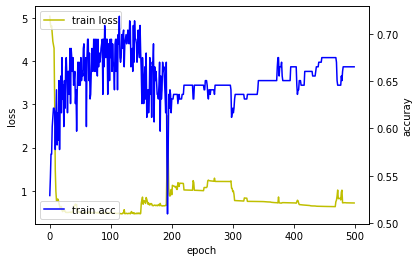

In [20]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### Test model

In [21]:
predictions = model.predict(np.array(X_test).transpose([0,1,2,3]))
if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Test AUC:  0.5703125


In [22]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency

array([13., 29.])

In [23]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

2/2 - 0s - loss: 1.3100 - accuracy: 0.4524 - auc: 0.5397

Accuracy: 0.4523809552192688
